Implementation of JAX Library for DRCAT Dataset for SML Project - ASU

In [52]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training import train_state
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast
from datasets import Dataset

In [53]:
# --- Configuration ---
class Config:
    max_vocab_size = 20000
    max_seq_len = 200
    embedding_dim = 128
    hidden_dim = 64
    batch_size = 32
    num_epochs = 5
    learning_rate = 1e-3
    seed = 42

# --- Load Data ---
df = pd.read_csv("/Users/pranay/Desktop/smlJax/kaggledataset/train_drcat_04.csv")  # Training data
df = df[["text", "label"]]  # 'label' is already the correct column

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=Config.seed
)


In [76]:
# Load Test Data
test_df = pd.read_csv("/Users/pranay/Desktop/smlJax/kaggledataset/ai-ga-dataset.csv")
test_df["content"] = test_df["title"]+". "+test_df["abstract"]
test_texts = test_df["content"].tolist()
test_labels = test_df["label"].tolist()

# --- Tokenization ---
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_batch(texts):
    return tokenizer(
        texts,
        max_length=Config.max_seq_len,
        truncation=True,
        padding="max_length",
        return_tensors="np"
    )

train_encodings = tokenize_batch(train_texts)
val_encodings = tokenize_batch(val_texts)
test_encodings = tokenize_batch(test_texts)

In [77]:
# --- Dataset Preparation ---
def make_dataset(encodings, labels):
    return {
        "input_ids": encodings["input_ids"].astype(np.int32),
        "attention_mask": encodings["attention_mask"].astype(np.int32),
        "labels": np.array(labels).astype(np.int32)
    }

train_dataset = make_dataset(train_encodings, train_labels)
val_dataset = make_dataset(val_encodings, val_labels)
test_dataset = make_dataset(test_encodings, test_labels)


In [79]:
# --- Model Definition ---
class FakeTextClassifier(nn.Module):
    vocab_size: int
    embedding_dim: int
    hidden_dim: int

    @nn.compact
    def __call__(self, input_ids):
        x = nn.Embed(num_embeddings=self.vocab_size, features=self.embedding_dim)(input_ids)
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(2)(x)  # Binary classification
        return x

In [80]:
# --- Utility Functions ---
def cross_entropy_loss(logits, labels):
    return optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()

def compute_metrics(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(predictions == labels)
    return {"accuracy": acc, "predictions": predictions}

# --- Training State ---
def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((Config.batch_size, Config.max_seq_len), dtype=jnp.int32))
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# --- Training Step ---
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn(params, batch["input_ids"])
        loss = cross_entropy_loss(logits, batch["labels"])
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, batch["labels"])
    return state, metrics

In [81]:
# --- Evaluation Step ---
@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn(state.params, batch["input_ids"])
    return compute_metrics(logits, batch["labels"])

# --- Batching Utility ---
def data_iterator(dataset, batch_size):
    n = len(dataset["input_ids"])
    indices = np.arange(n)
    np.random.shuffle(indices)
    for i in range(0, n, batch_size):
        batch_idx = indices[i:i+batch_size]
        yield {
            "input_ids": dataset["input_ids"][batch_idx],
            "labels": dataset["labels"][batch_idx]
        }

# --- Training Loop ---
model = FakeTextClassifier(vocab_size=tokenizer.vocab_size, embedding_dim=Config.embedding_dim, hidden_dim=Config.hidden_dim)
rng = jax.random.PRNGKey(Config.seed)
state = create_train_state(rng, model, Config.learning_rate)

for epoch in range(Config.num_epochs):
    print(f"Epoch {epoch+1}/{Config.num_epochs}")
    # Training
    for batch in data_iterator(train_dataset, Config.batch_size):
        state, train_metrics = train_step(state, batch)

    # Validation
    val_metrics = []
    for batch in data_iterator(val_dataset, Config.batch_size):
        metrics = eval_step(state, batch)
        val_metrics.append(metrics["accuracy"])

    print(f"  Val Accuracy: {np.mean(val_metrics):.4f}")



Epoch 1/5
  Val Accuracy: 0.9839
Epoch 2/5
  Val Accuracy: 0.9841
Epoch 3/5
  Val Accuracy: 0.9821
Epoch 4/5
  Val Accuracy: 0.9831
Epoch 5/5
  Val Accuracy: 0.9832


In [82]:
# --- Test Evaluation ---
test_predictions = []
test_labels_collected = []

for batch in data_iterator(test_dataset, Config.batch_size):
    metrics = eval_step(state, batch)
    test_predictions.extend(np.array(metrics["predictions"]))
    test_labels_collected.extend(np.array(batch["labels"]))

print("\n--- Test Set Evaluation ---")
print(classification_report(test_labels_collected, test_predictions))


--- Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.66      0.59      0.63     14331
           1       0.63      0.70      0.66     14331

    accuracy                           0.65     28662
   macro avg       0.65      0.65      0.64     28662
weighted avg       0.65      0.65      0.64     28662



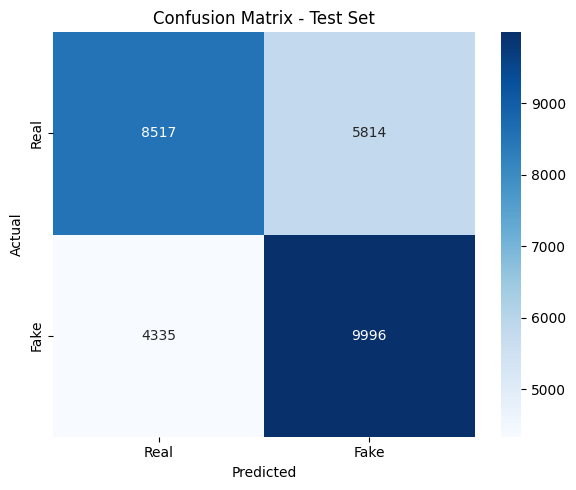

In [83]:
# --- Confusion Matrix ---
cm = confusion_matrix(test_labels_collected, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

In [84]:
# --- Save Predictions to CSV ---
pred_df = pd.DataFrame({
    "text": test_texts,
    "actual": test_labels,
    "predicted": test_predictions
})
pred_df.to_csv("test_predictions_output.csv", index=False)
print("Predictions saved to test_predictions_output.csv")

Predictions saved to test_predictions_output.csv


/var/folders/16/ynvb9wpd4msdhcbwczh6y6_m0000gn/T/ipykernel_6917/213911097.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette=colors)


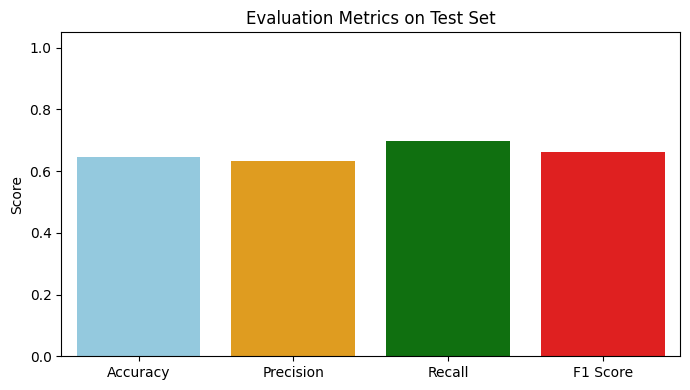

In [85]:
# --- Evaluation Metrics Plot ---
acc = accuracy_score(test_labels_collected, test_predictions)
prec = precision_score(test_labels_collected, test_predictions)
rec = recall_score(test_labels_collected, test_predictions)
f1 = f1_score(test_labels_collected, test_predictions)

metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1}
colors = ["skyblue", "orange", "green", "red"]

plt.figure(figsize=(7, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette=colors)
plt.ylim(0, 1.05)
plt.title("Evaluation Metrics on Test Set")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


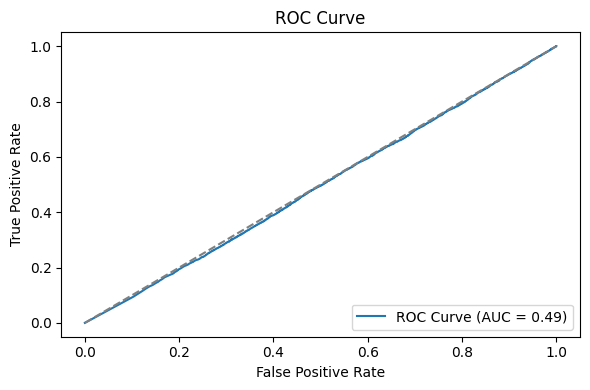

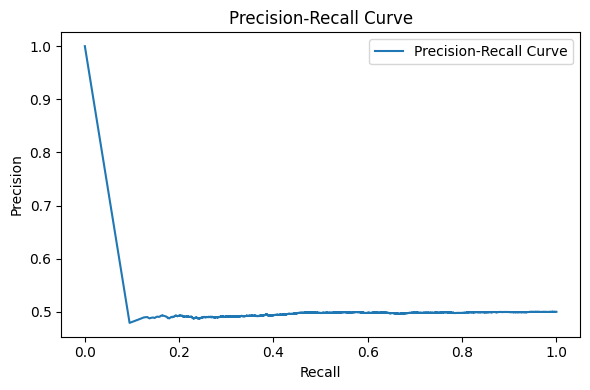

In [86]:
from sklearn.preprocessing import label_binarize

test_probs = []
for batch in data_iterator(test_dataset, Config.batch_size):
    logits = state.apply_fn(state.params, batch["input_ids"])
    probs = jax.nn.softmax(logits, axis=-1)
    test_probs.extend(np.array(probs))

test_probs = np.array(test_probs)
test_labels_bin = label_binarize(test_labels_collected, classes=[0, 1]).ravel()
test_scores = test_probs[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels_bin, test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels_bin, test_scores)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()
